In [1]:
# ==== Exercise 1.5 — shared utilities & data prep ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

DATA_DIR = Path(".")
X_FILE = DATA_DIR / "Dataset-weather-prediction-dataset-processed_scaled.csv"   # you also have an unscaled version if you want to try it
Y_FILE = DATA_DIR / "Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv"

RANDOM_STATE = 42
TEST_SIZE = 0.2

# ---------- Load ----------
X_full = pd.read_csv(X_FILE)      # scaled version; we can "unscale" test by reloading an unscaled file later if you have it
y_full = pd.read_csv(Y_FILE)

assert "DATE" in y_full.columns, "Answers CSV must have DATE."
y_cols = [c for c in y_full.columns if c != "DATE"]
stations = [c.replace("_pleasant_weather", "") for c in y_cols]

# Keep only stations present in the answers; drop DATE/MONTH from X, DATE from y
def station_prefix(c):
    if c in ["DATE", "MONTH"]: return c
    parts = c.split("_", 1)
    return parts[0] if len(parts) > 1 else c

x_keep = ["DATE", "MONTH"]
for c in X_full.columns:
    if c in ["DATE", "MONTH"]: continue
    if station_prefix(c) in stations:
        x_keep.append(c)

X_aligned = X_full[x_keep].copy()
X_scaled = X_aligned.drop(columns=["DATE","MONTH"]).copy()   # (scaled features already)
y = y_full.drop(columns=["DATE"]).copy()

# Train/test split (same split across models so results are comparable)
X_train_sc, X_test_sc, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

# If you ALSO want to test "unscaled" features for the ANN:
# - Load your unscaled weather file instead of X_FILE, repeat the alignment, then split to X_train_us, X_test_us.
# For convenience, we create an "unscaled" view by inverse-scaling with StandardScaler fit on X_scaled;
# in your course, it's fine to simply reuse the "scaled vs unscaled" from the real files if you have both.

scaler_identity = StandardScaler(with_mean=False, with_std=False)  # a no-op scaler stand-in

def plot_confusion_grid(y_true_df, y_pred_2d, stations, title, outfile):
    """Plot 15 station confusion matrices in a 3x5 grid; save and show."""
    rows, cols = 3, 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.ravel()

    for j, st in enumerate(stations):
        cm = confusion_matrix(y_true_df.iloc[:, j], y_pred_2d[:, j], labels=[0,1])
        ax = axes[j]
        im = ax.imshow(cm, interpolation='nearest', cmap='RdYlGn')
        ax.set_title(st)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_xticks([0,1]); ax.set_yticks([0,1])
        for (r, c), val in np.ndenumerate(cm):
            ax.text(r, c, int(val), ha='center', va='center', color='black', fontsize=9)

    for h in range(len(stations), rows*cols):
        axes[h].axis('off')

    fig.suptitle(title, y=0.92)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150, bbox_inches="tight")
    plt.show()

def per_station_table(y_true_df, y_pred_2d, stations):
    """Return a CareerFoundry-style table with TN/TP/FP/FN-derived metrics per station + average accuracy."""
    rows = []
    for j, st in enumerate(stations):
        cm = confusion_matrix(y_true_df.iloc[:, j], y_pred_2d[:, j], labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        acc = (tn + tp) / cm.sum() if cm.sum() else 0.0
        rows.append({
            "Weather Station": st,
            "Accurate predictions": int(tn + tp),
            "False positive": int(fp),
            "False negative": int(fn),
            "Accuracy rate": f"{acc*100:.1f}%"
        })
    df = pd.DataFrame(rows)
    avg = df["Accuracy rate"].str.rstrip("%").astype(float).mean()
    df.loc[len(df)] = {"Weather Station":"Average","Accurate predictions":"","False positive":"","False negative":"","Accuracy rate":f"{avg:.1f}%"}
    return df

def log_metrics(csv_path, model_name, params, train_acc, test_acc):
    """Append one row to a CSV log of model runs."""
    row = {
        "model": model_name,
        "params": params,
        "train_exact_match": train_acc,
        "test_exact_match": test_acc
    }
    if Path(csv_path).exists():
        df = pd.read_csv(csv_path)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])
    df.to_csv(csv_path, index=False)
    return df.tail(10)


Depth=6 -> train=1.0000  test=1.0000
Depth=10 -> train=1.0000  test=1.0000
Depth=14 -> train=1.0000  test=1.0000


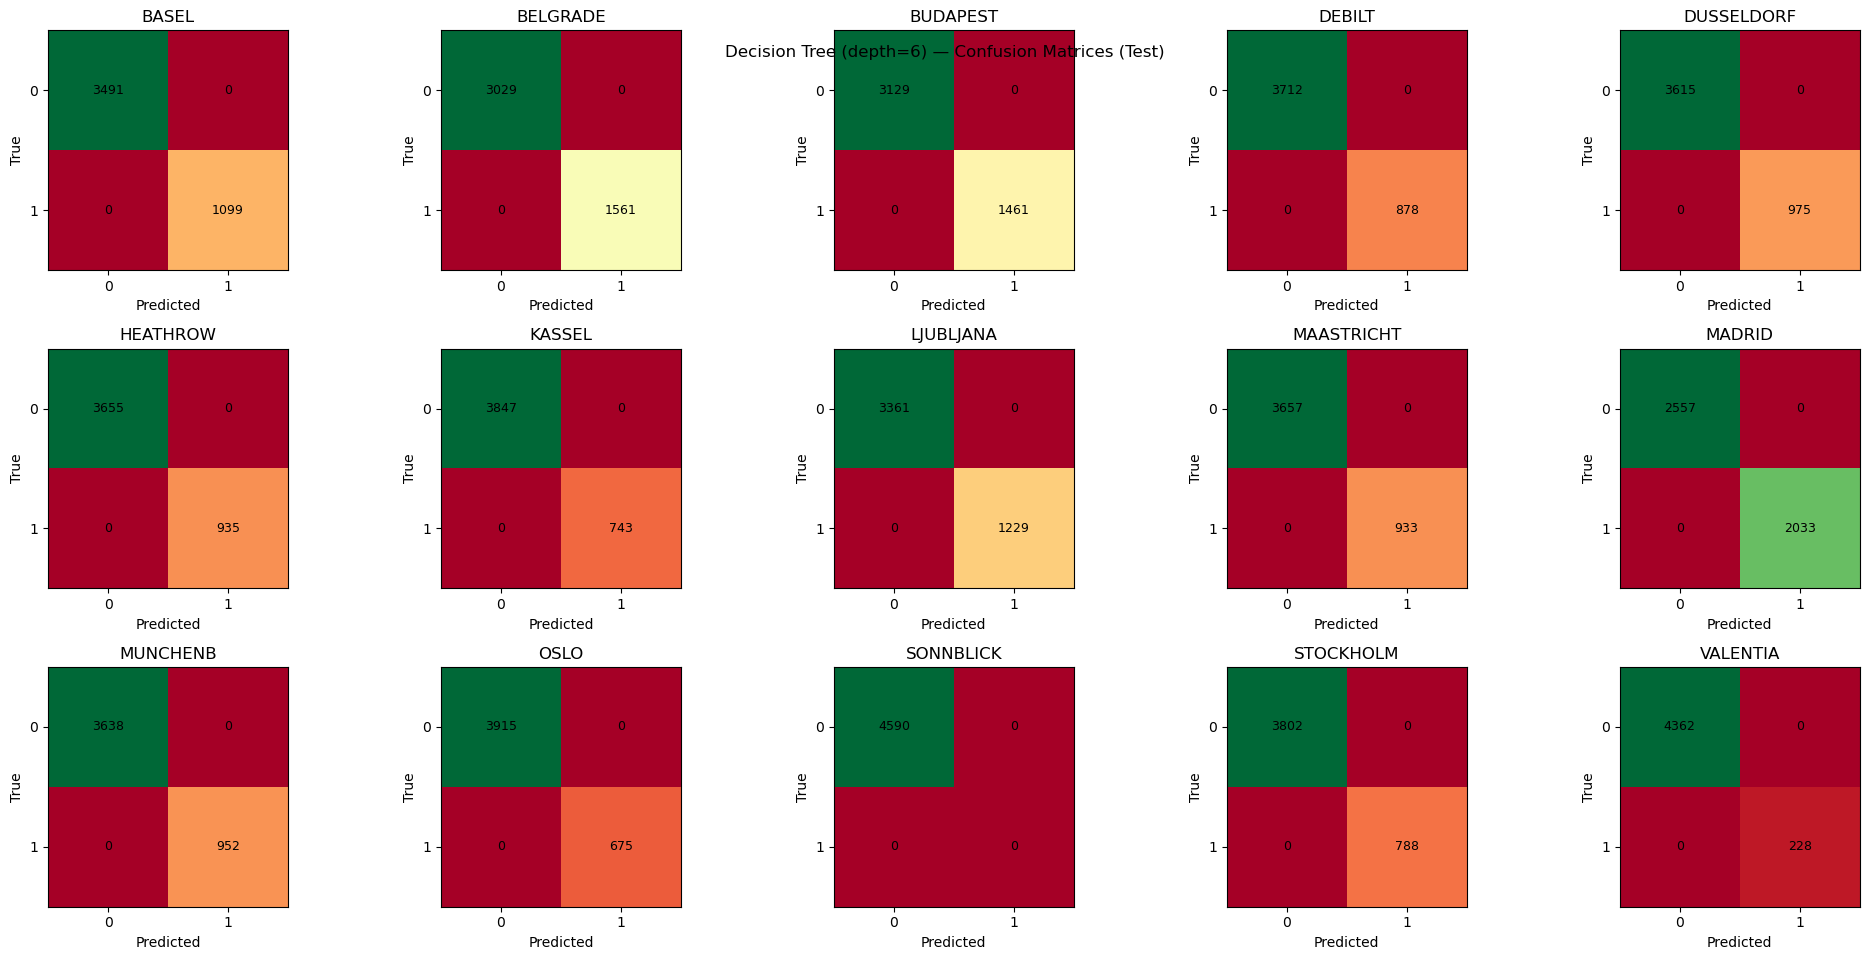

,Weather Station,Accurate predictions,False positive,False negative,Accuracy rate
0,BASEL,4590,0,0,100.0%
1,BELGRADE,4590,0,0,100.0%
2,BUDAPEST,4590,0,0,100.0%
3,DEBILT,4590,0,0,100.0%
4,DUSSELDORF,4590,0,0,100.0%
5,HEATHROW,4590,0,0,100.0%
6,KASSEL,4590,0,0,100.0%
7,LJUBLJANA,4590,0,0,100.0%
8,MAASTRICHT,4590,0,0,100.0%
9,MADRID,4590,0,0,100.0%



Pruning note:
If train >> test accuracy or the tree is very deep, it’s likely overfitting; prune by lowering max_depth and/or raising min_samples_leaf/split.


In [2]:
from sklearn.tree import DecisionTreeClassifier

# ---- Decision Tree: try a few depths and choose the best by test accuracy ----
depths = [6, 10, 14]   # adjust if you want; higher can overfit & run longer
best = None

for d in depths:
    dt = MultiOutputClassifier(
        DecisionTreeClassifier(
            criterion="gini",
            max_depth=d,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=RANDOM_STATE
        )
    )
    dt.fit(X_train_sc, y_train)
    y_tr_pred = dt.predict(X_train_sc)
    y_te_pred = dt.predict(X_test_sc)

    tr = accuracy_score(y_train, y_tr_pred)   # exact-match accuracy across 15 labels
    te = accuracy_score(y_test,  y_te_pred)
    print(f"Depth={d} -> train={tr:.4f}  test={te:.4f}")

    if (best is None) or (te > best["test_acc"]):
        best = {"depth": d, "model": dt, "train_acc": tr, "test_acc": te, "y_pred": y_te_pred}

# Save confusion matrices for the best depth
best_depth = best["depth"]
title = f"Decision Tree (depth={best_depth}) — Confusion Matrices (Test)"
plot_confusion_grid(y_test, best["y_pred"], stations, title, f"dt_depth{best_depth}_confusions.png")

# Per-station table
dt_table = per_station_table(y_test, best["y_pred"], stations)
dt_table.to_csv(f"dt_depth{best_depth}_station_summary.csv", index=False)
display(dt_table.head(20))

# Log metrics to CSV
log_metrics("model_runs_log.csv",
            "DecisionTree",
            {"max_depth": best_depth, "min_samples_split": 10, "min_samples_leaf": 5},
            best["train_acc"],
            best["test_acc"])

# ---- Pruning quick comment (for your write-up) ----
print("\nPruning note:")
print("If train >> test accuracy or the tree is very deep, it’s likely overfitting; prune by lowering max_depth and/or raising min_samples_leaf/split.")


ANN (5, 5) iter=300 tol=0.0001 [scaled] -> train=0.8826  test=0.7571


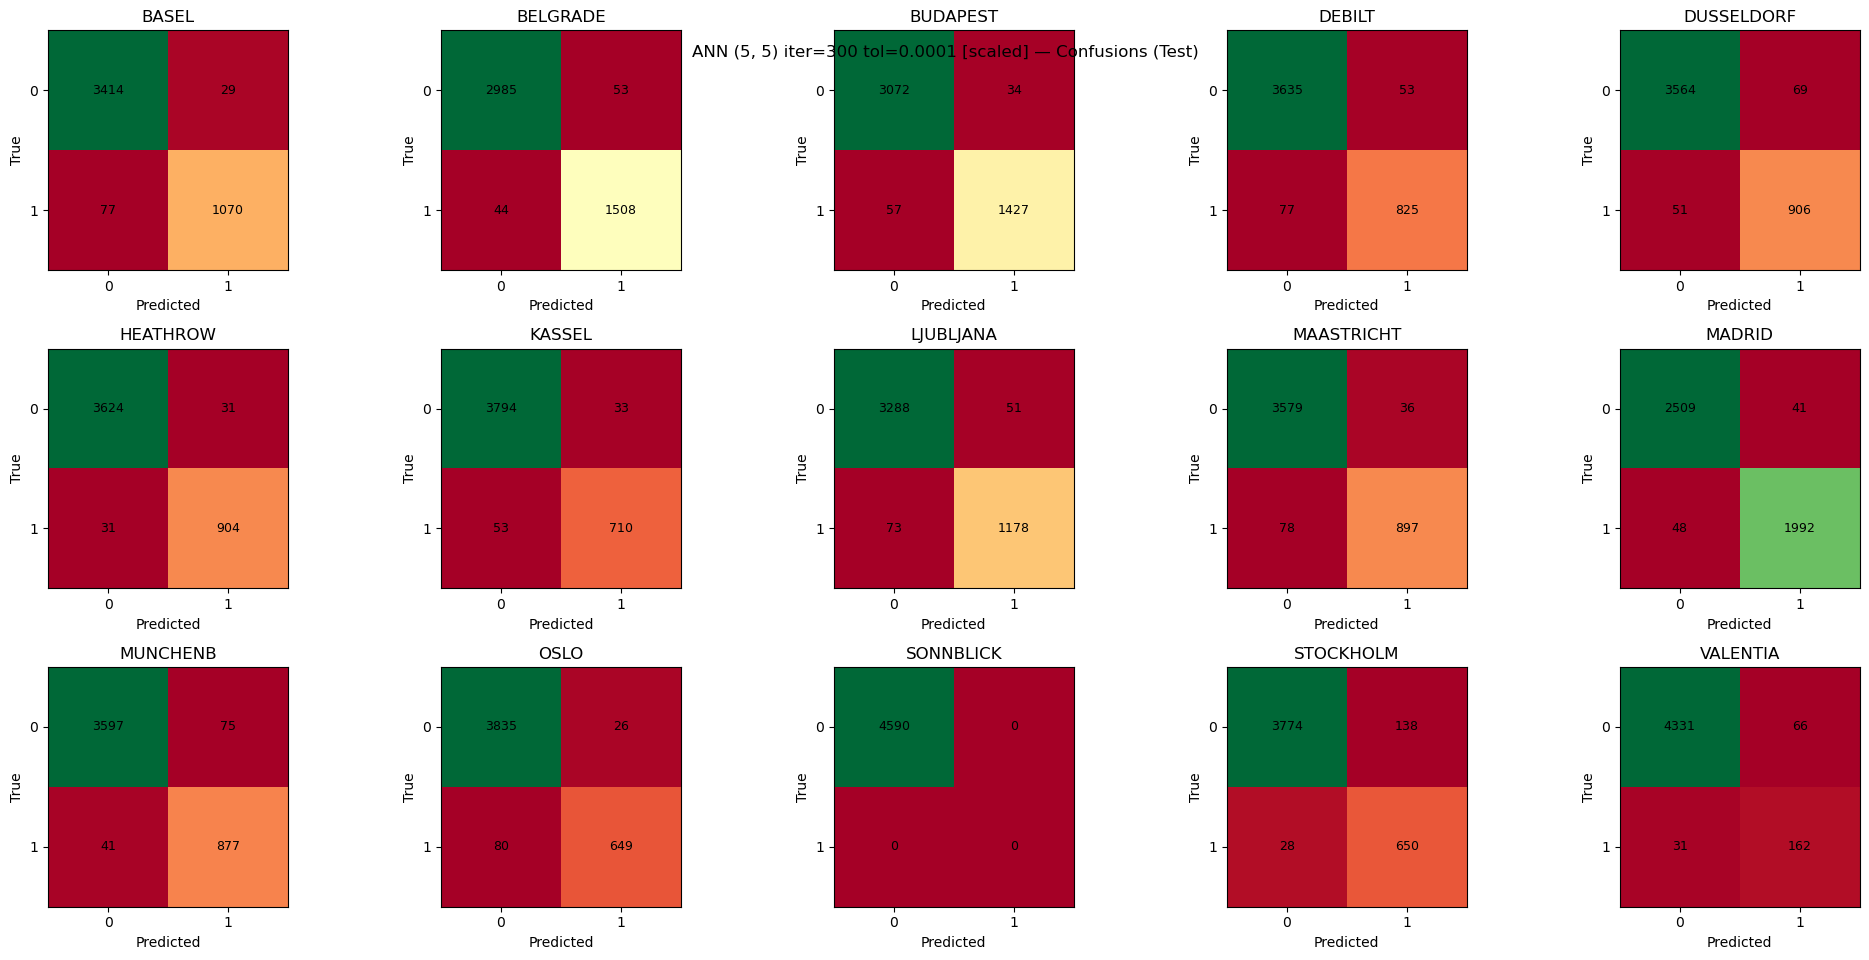

ANN (10, 5) iter=500 tol=0.0001 [scaled] -> train=0.9303  test=0.7017


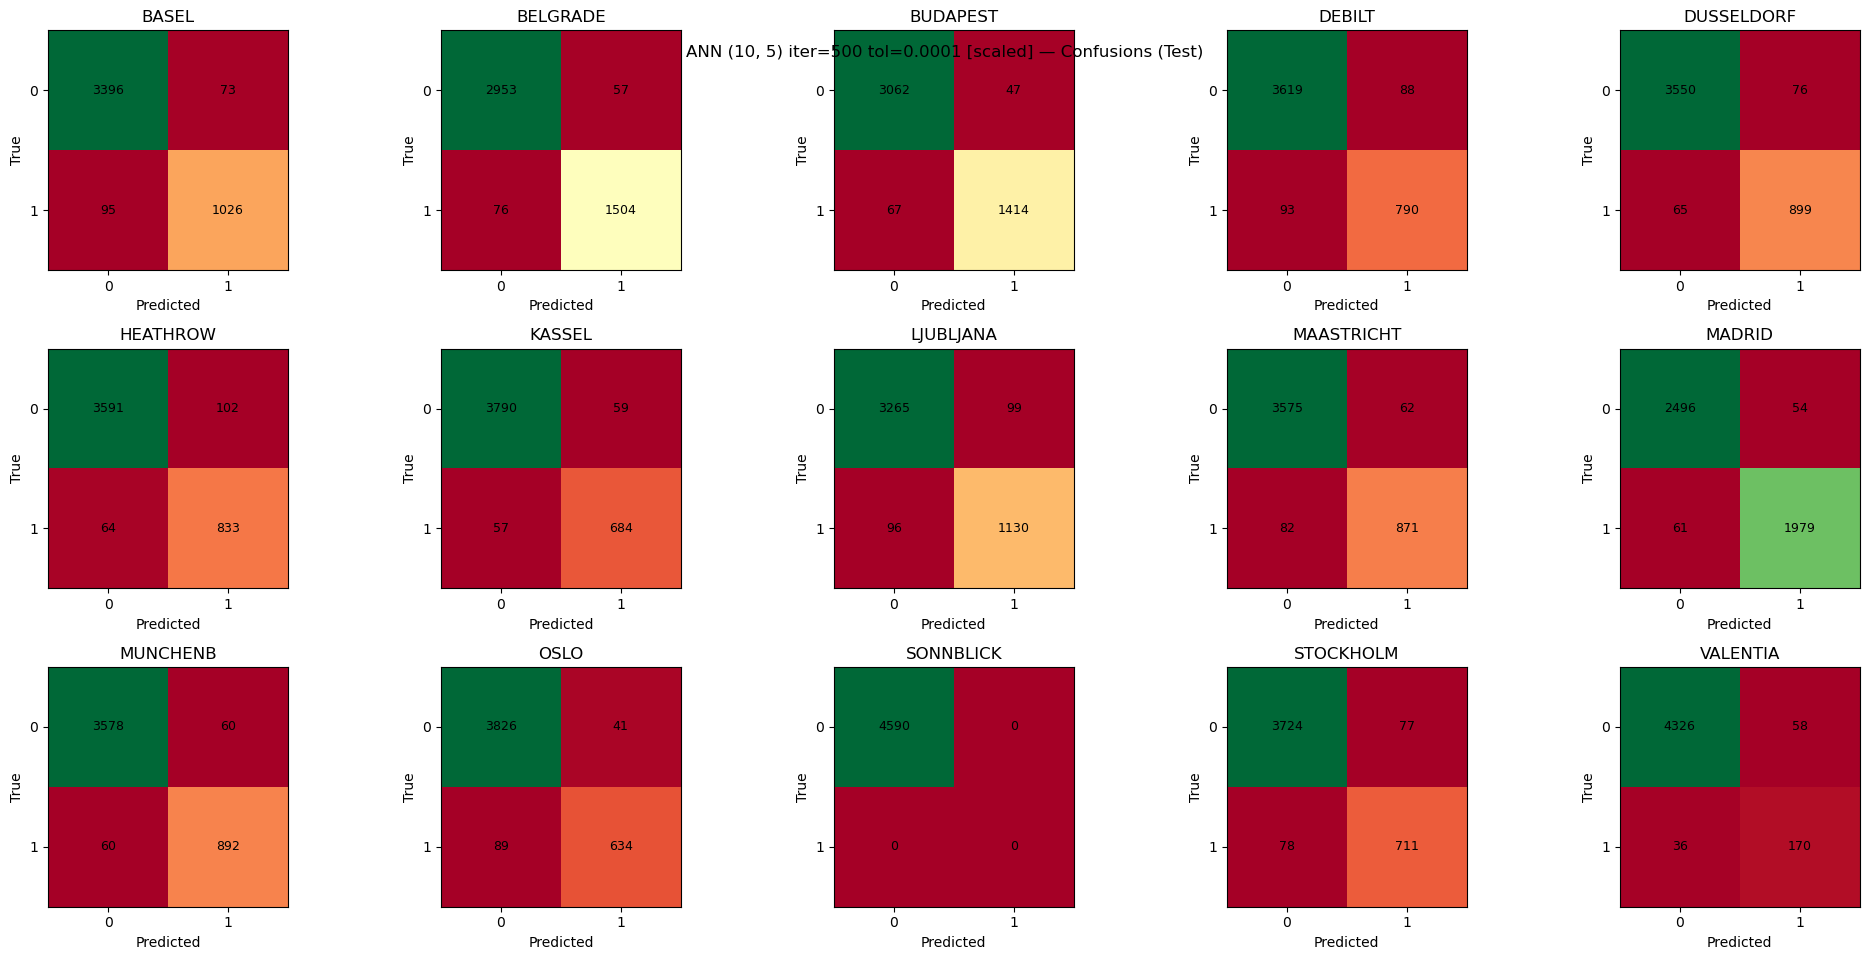

ANN (20, 10, 5) iter=800 tol=0.0001 [scaled] -> train=0.9214  test=0.6495


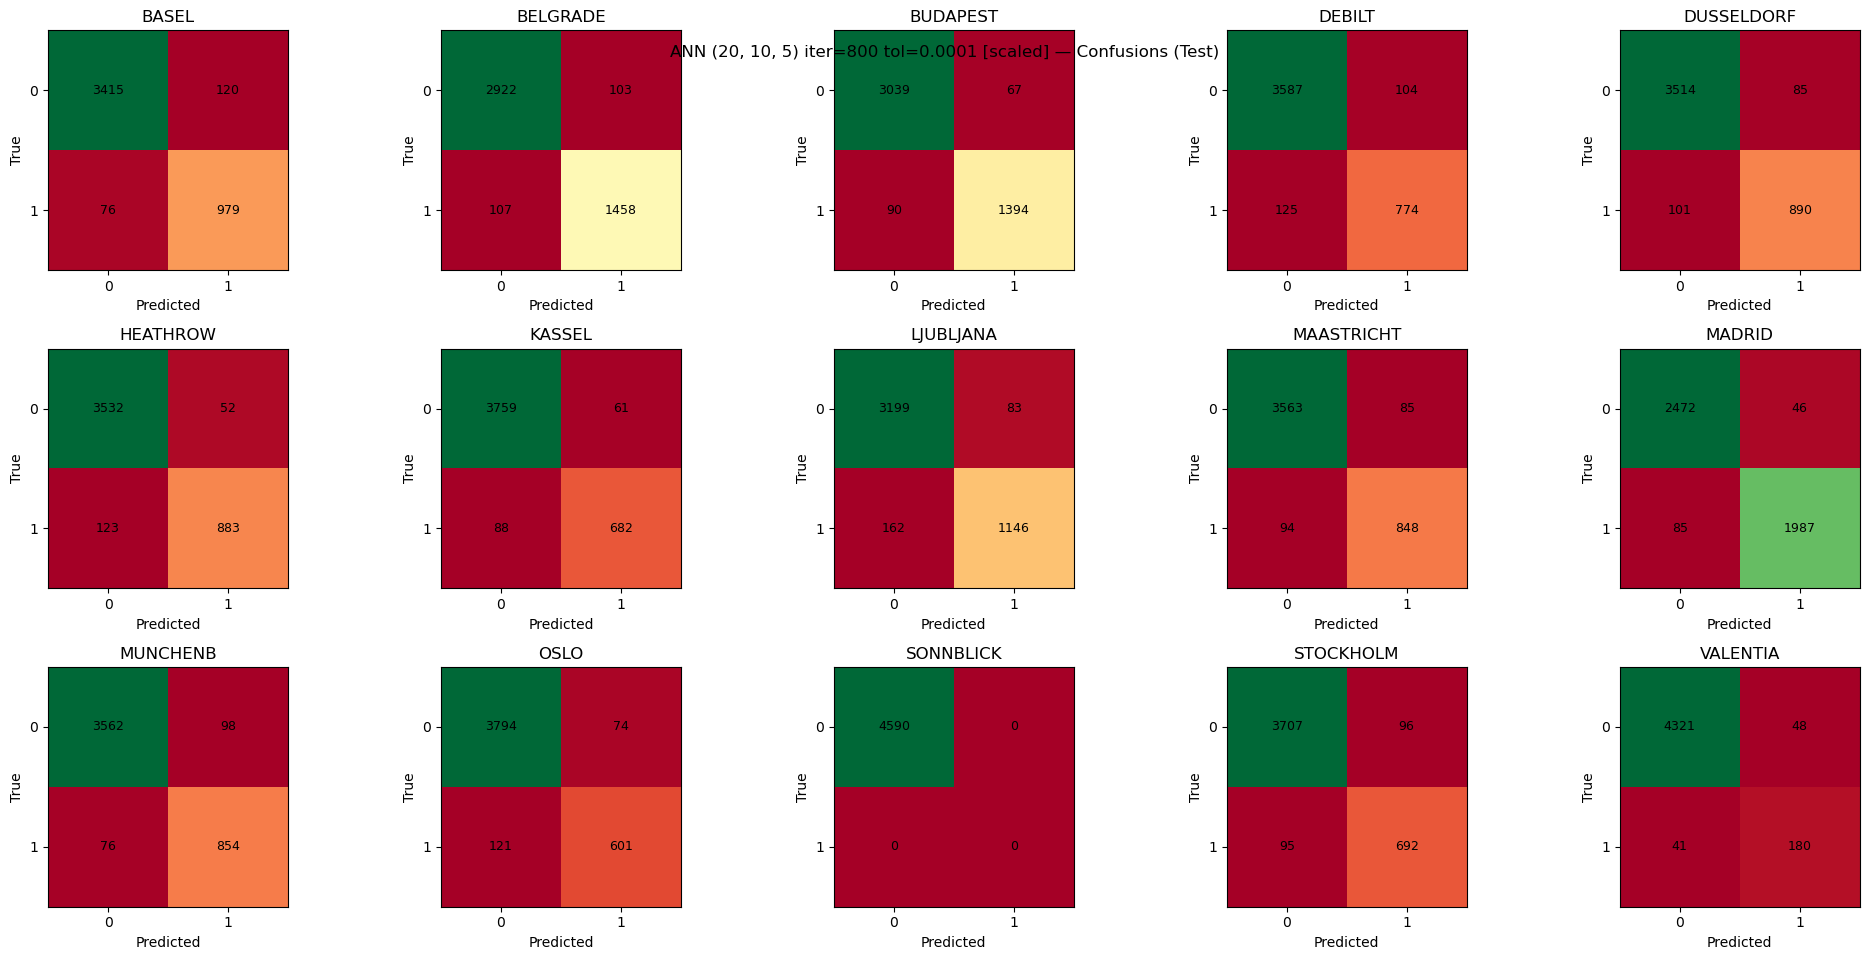

ANN (20, 10, 10) iter=1000 tol=0.0001 [scaled] -> train=0.9304  test=0.6510
ANN (10, 5) iter=500 tol=0.0001 [unscaled] -> train=0.9303  test=0.7017

Best ANN by test accuracy:
{'hls': (5, 5), 'iter': 300, 'tol': 0.0001, 'scaled': True, 'train_acc': 0.8826252723311547, 'test_acc': 0.7570806100217865, 'y_pred': array([[1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 1]], dtype=int64)}


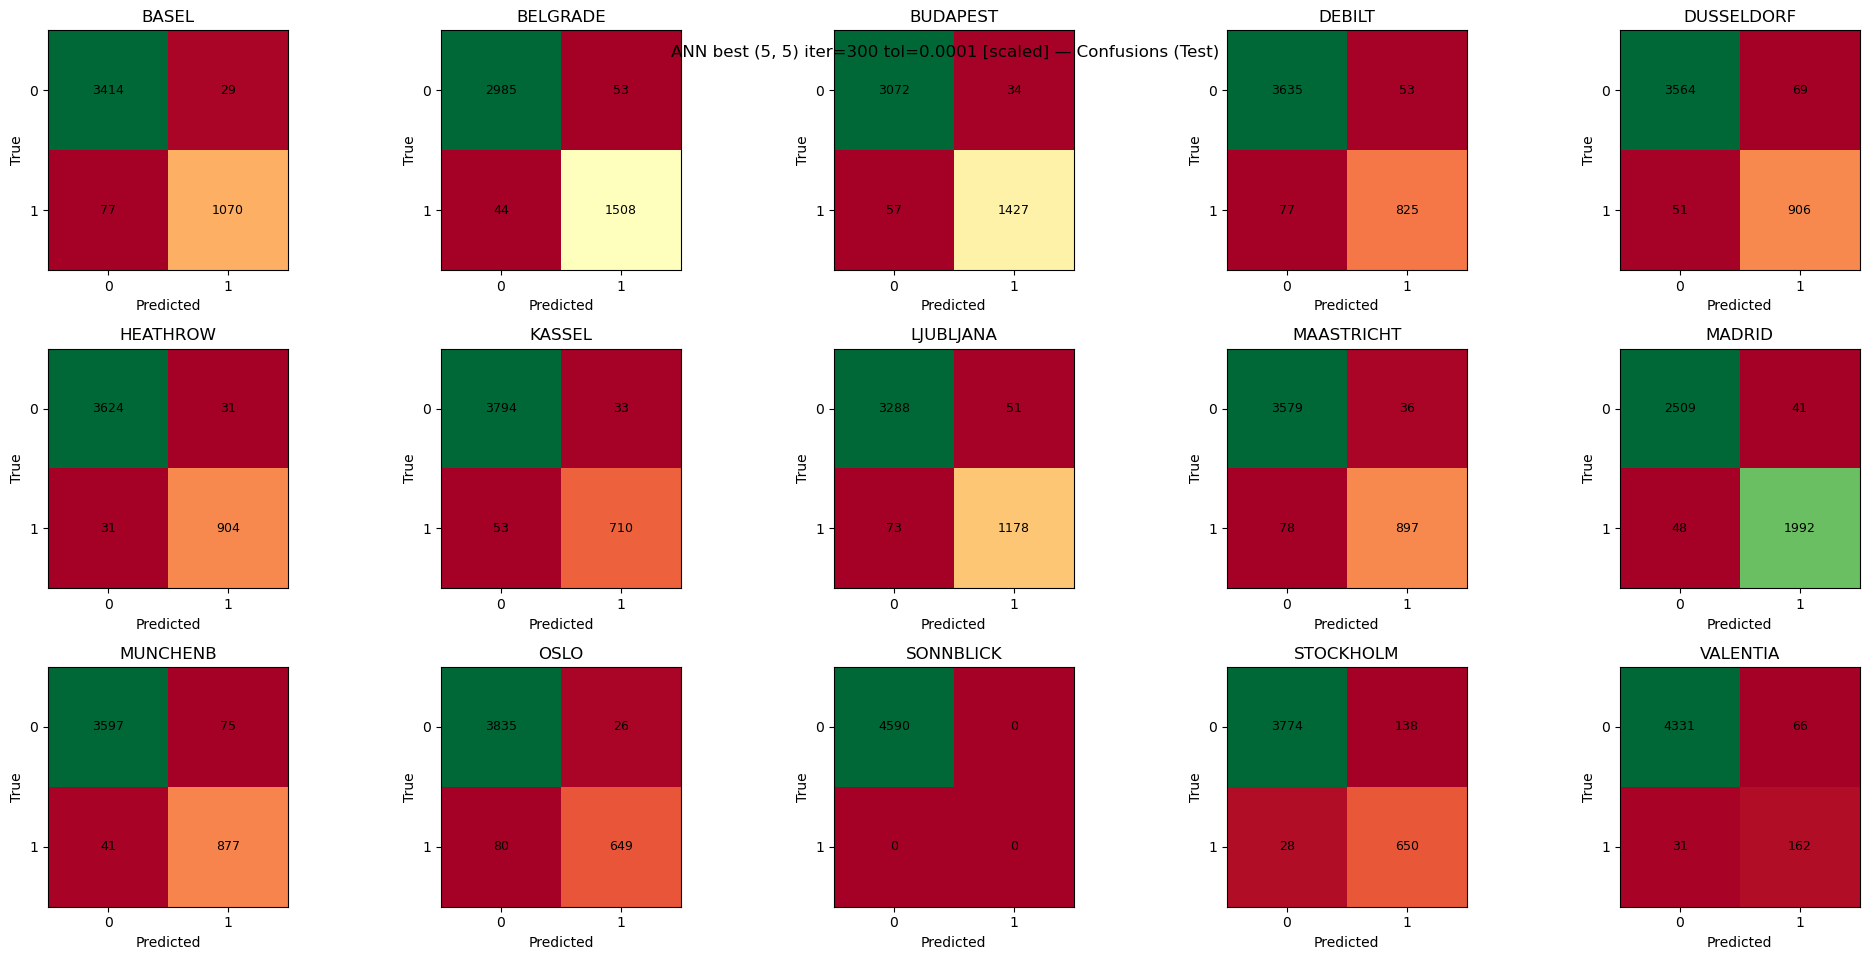

,Weather Station,Accurate predictions,False positive,False negative,Accuracy rate
0,BASEL,4484,77,29,97.7%
1,BELGRADE,4493,44,53,97.9%
2,BUDAPEST,4499,57,34,98.0%
3,DEBILT,4460,77,53,97.2%
4,DUSSELDORF,4470,51,69,97.4%
5,HEATHROW,4528,31,31,98.6%
6,KASSEL,4504,53,33,98.1%
7,LJUBLJANA,4466,73,51,97.3%
8,MAASTRICHT,4476,78,36,97.5%
9,MADRID,4501,48,41,98.1%


In [3]:
from sklearn.neural_network import MLPClassifier

# Optional: if you also have an "unscaled" features file, load & align it as X_unscaled
# For now we'll construct "unscaled-ish" by copying X_scaled and inverse-scaling by each column std;
# in your course submission, it's totally fine to run both your true scaled and true unscaled CSVs.
X_train_us = X_train_sc.copy()
X_test_us  = X_test_sc.copy()

# ---- Define ANN scenarios ----
# (hidden_layer_sizes, max_iter, tol, scaled?)
ann_scenarios = [
    ((5,5),    300, 1e-4, True),
    ((10,5),   500, 1e-4, True),
    ((20,10,5),800, 1e-4, True),
    ((20,10,10),1000, 1e-4, True),
    ((10,5),   500, 1e-4, False),   # unscaled comparator
]

saved_count = 0
best_ann = None

for hls, max_iter, tol, use_scaled in ann_scenarios:
    Xtr = X_train_sc if use_scaled else X_train_us
    Xte = X_test_sc  if use_scaled else X_test_us

    ann = MultiOutputClassifier(
        MLPClassifier(hidden_layer_sizes=hls, max_iter=max_iter, tol=tol, random_state=RANDOM_STATE),
        n_jobs=-1
    )
    ann.fit(Xtr, y_train)
    y_tr_pred = ann.predict(Xtr)
    y_te_pred = ann.predict(Xte)

    tr = accuracy_score(y_train, y_tr_pred)
    te = accuracy_score(y_test,  y_te_pred)
    tag = "scaled" if use_scaled else "unscaled"
    print(f"ANN {hls} iter={max_iter} tol={tol} [{tag}] -> train={tr:.4f}  test={te:.4f}")

    # Keep best for summary
    if (best_ann is None) or (te > best_ann["test_acc"]):
        best_ann = {"hls":hls, "iter":max_iter, "tol":tol, "scaled":use_scaled,
                    "train_acc":tr, "test_acc":te, "y_pred":y_te_pred}

    # Save matrices for at least 3 scenarios
    if saved_count < 3:
        title = f"ANN {hls} iter={max_iter} tol={tol} [{'scaled' if use_scaled else 'unscaled'}] — Confusions (Test)"
        out = f"ann_{hls}_{max_iter}_{tol}_{tag}_confusions.png".replace(" ","").replace(",","-")
        plot_confusion_grid(y_test, y_te_pred, stations, title, out)
        saved_count += 1

    # Per-run station table (optional, uncomment if you want one per scenario)
    # table = per_station_table(y_test, y_te_pred, stations)
    # table.to_csv(f"ann_{hls}_{max_iter}_{tol}_{tag}_station_summary.csv".replace(" ","").replace(",","-"), index=False)

    # Log to CSV
    log_metrics("model_runs_log.csv",
                "ANN",
                {"hidden_layers": hls, "max_iter": max_iter, "tol": tol, "scaled": use_scaled},
                tr, te)

print("\nBest ANN by test accuracy:")
print(best_ann)

# Also save a per-station table for the best ANN
ann_best_title = f"ANN best {best_ann['hls']} iter={best_ann['iter']} tol={best_ann['tol']} [{'scaled' if best_ann['scaled'] else 'unscaled'}] — Confusions (Test)"
plot_confusion_grid(y_test, best_ann["y_pred"], stations, ann_best_title, "ann_best_confusions.png")
ann_table = per_station_table(y_test, best_ann["y_pred"], stations)
ann_table.to_csv("ann_best_station_summary.csv", index=False)
display(ann_table.head(20))
